In [368]:
import sys
#sys.path.append("~/Documents/qubitlab/python/qutip")
from libqubit2d import *
from scipy.optimize import *
from scipy.integrate import *

In [101]:
class ND(Model):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    class_params = ['params']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.evals, self.evecs = self.Hq().eigenstates()
        self.params['w'] = self.evals[1] - self.evals[0]
        self.params['psi0'] = self.evecs[0]
        self.update_pulse(params={'w':self.params['w']})
        return self
    def n(self):
        return num(2*self.params['N']+1, offset = -self.params['N'])

    def I(self):
        return identity(2*self.params['N']+1)

    def Hc(self):
        return 2*np.pi*4*self.params['Ec']*(self.n())**2

    def Hj(self):
        return -0.5*2*np.pi*self.params['Ej']*Qobj(np.diag(np.ones(2*self.params['N']), -1)+np.diag(np.ones(2*self.params['N']), 1))

    def Hq(self):
        return self.Hc() + self.Hj()

    def c(self):
        return sum([self.n().matrix_element(self.evecs[j], self.evecs[j+1])/self.n().matrix_element(self.evecs[0], self.evecs[1])\
                        * self.evecs[j]*self.evecs[j+1].dag() for j in range(0, len(self.evecs)-1)])
    def get_anharmonism(self, recount = False):
        if recount:
            self.evals, self.evecs = self.Hq().eigenstates()
        return -(self.evals[2] - self.evals[1]) + (self.evals[1] - self.evals[0])
    def collapse_list(self, c_op = None):
        collapse_list = []
        if c_op is None:
            c_op = self.c()
        if(self.params['gamma_m']> 0):
            collapse_list.append(np.sqrt(self.params['gamma_m']) * c_op )
        return collapse_list

    def S_basis(self):
        S = [[el[0] for el in evec.data.toarray()] for evec in self.evecs ]
        return Qobj(S)
    
    def raise_dim_2toN(self,A2d,base = 'zero'):
        B2d = A2d.data.toarray()
        A = base
        if base is 'zero':
            A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq
    
    def convert_2toN(self, A2d):
        B2d = A2d.data.toarray()
        A = np.zeros(shape=(len(self.evecs),len(self.evecs)),dtype=np.complex128)
        A[0][0] = B2d[0][0]
        A[0][1] = B2d[0][1]
        A[1][0] = B2d[1][0]
        A[1][1] = B2d[1][1]
        Aq = Qobj(A)
        return Aq.transform(self.evecs,True)

    def Hq_evecs(self):
        return self.Hq().eigenstates()[1]
    def Hq_evals(self):
        return self.Hq().eigenstates()[0]

    def rotatingFrame(self, expected_ops,  output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        Hq = self.Hq()
        for i, eop in enumerate(expected_ops):
            output.expect[i] = [ expect((-1j*Hq * time).expm() * eop * (1j*Hq * time).expm(), state) for time, state in zip(self.timelist(),output.states) ]
        return output
    def rotateStates(self,output = None):
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        szn = self.convert_2toN(sigmaz())
        U = (-1j*self.Hq()* 0).expm()
        dt = self.timelist()[-1] / (len(self.timelist())-1)
        new_states = []
        Hq = self.Hq()
        output.states = [(1j*Hq * time).expm() * state for time, state in zip(self.timelist(), output.states)]
            
        #for time_step, state in enumerate(output.states):
        #    time = dt * time_step
        #    U  = (-1j*Hq * time).expm()
        #    new_states.append( U * output.states[i])
        #output.states = new_states
        return output
    def expectOperators(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()], output = None):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        if output is None:
            try:
                output = self.result
            except AttributeError:
                print ("Error: no present result")
        output.expect = []
        for i in range(len(expected_ops)):
            output.expect.append([])
        for state in output.states:
            for i, eop in enumerate(expected_ops):
                output.expect[i].append(expect(eop, state))    
        return output

In [102]:
class EasyShiftable:
    def shift(self, deltat):
        self.update(params={'a': self.params['a'] + deltat, 'b': self.params['b'] + deltat})
    def get_left(self, EPS = 1e-5):
        return self.params['a']
    def get_right(self, EPS = 1e-5):
        return self.params['b']

In [358]:
class PulseNXY(Pulse, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-5
    default = Empty()
    default.params = {
        'f' : 0.1,
        'a':2.5,
        'b':2.5 + 3.92,
        'st':0.001,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*0.5*(tanh((t-a)/st) - tanh((t-b)/st) )*cos(w*t + axe )"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100),
        'auto' : True
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']
    def get_shape(self):
        return self.shape
    def contour(self, offset=0):
        spf = sp.sympify(self.get_shape())/sp.sympify("cos(w*t+axe)") + offset
        tosubs = []
        for k,v in self.params.items():
            tosubs.append((sp.symbols(k),v))
        new_spf = spf.subs(tosubs)
        return lambdify({'t'},str(new_spf),'numpy')
    def set_width(self, t):
        self.update(params={'width':t})
    def set_correct_width(self):
        if 'width' in self.params:
            self.params['b'] = self.params['a'] + self.params['width']
            self.params['f'] = np.abs(self.params['phase'])/self.params['width']/self.extra['n_ge']
        else:
            if abs(self.params['f']) < 1e-7:
                self.params['b'] = self.time['maxtime']
            else:
                self.params['b'] = self.params['a'] + np.abs(self.params['phase'])/self.params['f']/self.extra['n_ge']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['a'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['b'])
        if(self.time['auto']):
            if abs(self.params['f']) > 1e-7:
                self.time['maxtime'] = self.extra['b'] + self.extra['a']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        q = None
        if not self.extra['default']:
            try:
                n = self.extra['qubit'].n()
            except AttributeError:
                print ("Error: no qubit link provided")
                return
            self.extra['n_ge'] = abs(self.extra['qubit'].n().transform(self.extra['qubit'].evecs).data.toarray()[0][1])
            self.params['w'] = self.extra['qubit'].params['w']
        if not 'true_axe' in self.extra:
            self.extra['true_axe'] = self.params['axe']
        if not 'neg_axe' in self.extra:
            self.extra['neg_axe']  = (0 if self.params['phase'] > 0 else np.pi) 
        if 'axe' in kvargs['params']:
            self.extra['true_axe'] = kvargs['params']['axe']
        if 'phase' in params:
            self.extra['neg_axe'] = (0 if kvargs['params']['phase'] > 0 else np.pi)
        self.params['axe'] = self.extra['true_axe'] + self.extra['neg_axe']
        self.set_correct_width()
        return self
    def get_left(self):
        return self.extra['a']
    def get_right(self):
        return self.extra['b']        
                
    
        

In [104]:
class GaussianPulseNXY(PulseNXY, EasyShiftable):
    aroundX = 0
    aroundY = np.pi/2
    EPS = 1e-3
    default = Empty()
    default.params = {
        'f' : 0.1,
        'c' : 10,
        'st':10,
        'phase':0,
        'axe' : aroundX
    }
    default.time = {
        'points' : 100,
        'maxtime' : 20,
        'tlist' : np.linspace(0,10,100)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    default.shape = "f/(2*3.1415926)**0.5*(exp(-((t-c)/st)**2/2 ))*cos(w*t + axe)"
    class_params = ['params','time','shape', 'extra']
    def set_correct_width(self):
        self.params['f'] = self.params['phase']/self.extra['n_ge']/self.params['st']
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['c']-self.params['st'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['c']+self.params['st'])
    def shift(self, deltat):
        self.update(params={'c':self.params['c'] + deltat})

In [105]:
class WindowedPulse(Pulse):
    def make_window(self):
        self.shape = self.shape + "*0.5*(tanh((t-a)/st2) - tanh((t-b)/st2) )"
    def reset_magnitude(self):
        cf = self.contour()
        try:
            n_ge = self.extra['n_ge']
        except AttributeError:
            n_ge = 1
        ph = quad(cf, -np.inf, np.inf)[0]*n_ge
        self.params['f'] = self.params['phase']/ph * self.params['f']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy(kvargs, params, just_update)
        if not just_update:
            self.make_window()
        self.set_correct_width()
        self.reset_magnitude()
        return self
    def shift(self,deltat):
        super().shift( deltat)
        self.update(params={'a':self.params['a']+deltat,'b':self.params['b']+deltat})
    def set_correct_width(self):
        self.extra['a'] = fsolve(self.contour(-self.EPS),self.params['a'])
        self.extra['b'] = fsolve(self.contour(-self.EPS),self.params['b'])

In [106]:
class HTDCorrectedPulse:
    def correct(self):
        if not 'original_shape' in self.__dict__:
            self.original_shape = self.shape
        old_shape = sp.sympify(self.original_shape)
        w,t,axe = sp.symbols('w t axe')
        new_shape_y = sp.diff(old_shape/(sp.cos(w*t + axe)), t)
        new_shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*new_shape_y/2/self.extra['qubit'].get_anharmonism()
        self.shape = str(old_shape - new_shape_y)
    def get_shape(self):
        if 'original_shape' in self.__dict__:
            return self.original_shape
        else:
            return self.shape
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.correct() 
        return self

In [107]:
class PulseNXYHTD(HTDCorrectedPulse, PulseNXY):
    pass
       
class GaussianPulseNXYHTD( HTDCorrectedPulse, GaussianPulseNXY):
    pass
class GWPulseNXY(WindowedPulse, GaussianPulseNXY):
    pass
class GWPulseNXYHTD(HTDCorrectedPulse, WindowedPulse, GaussianPulseNXY):
    pass

In [301]:
class DRAGCorrectedPulse:
    def correct(self):
        if not 'original_shape' in self.__dict__:
            self.original_shape = self.shape
        if not 'leak_strength' in self.params:
            self.params['leak_strength'] = 2**0.5
        shape_x = sp.sympify(self.original_shape)
        w,t,axe = sp.symbols('w t axe')
        curvature = shape_x/(sp.cos(w*t + axe))
        anh = self.extra['qubit'].get_anharmonism()
        leak = self.params['leak_strength']
        
        shape_y = -sp.diff(curvature, t)/anh
        shape_y = shape_y + 33*(leak**2-2)*curvature**2*sp.diff(curvature, t)/24/anh**3
        shape_y = sp.cos(w*t+axe).subs(axe, axe + sp.pi/2)*shape_y
        
        shape_x = curvature
        shape_x = shape_x + (leak**2 - 4)*curvature**3/8/anh**2 - (13*leak**4-76*leak**2+112)*curvature**5/128/anh**4
        shape_x = sp.cos(w*t+axe)*shape_x
        
        detuning = curvature**2*(leak**2 - 4) / 4 / anh
        detuning = detuning - curvature**4*(leak**4 - 7*leak**2 + 12)/16/anh**3
        print(detuning)
        
        shape_x = shape_x.subs(axe, axe - detuning*t)
        shape_y = shape_y.subs(axe, axe - detuning*t)
        
        self.shape = str(shape_x + shape_y)
    def get_shape(self):
        if 'original_shape' in self.__dict__:
            return self.original_shape
        else:
            return self.shape
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.correct() 
        return self

In [302]:
class PulseNXYDRAG(DRAGCorrectedPulse, PulseNXY):
    pass
       
class GaussianPulseNXYDRAG( DRAGCorrectedPulse, GaussianPulseNXY):
    pass
class GWPulseNXYDRAG(DRAGCorrectedPulse, WindowedPulse, GaussianPulseNXY):
    pass

In [ ]:
class GrapeOptimizer()

In [303]:
class PulseSequence(Pulse):
    default = Empty()
    default.params = {}
    default.pulses = []
    default.shape = "0"
    default.time = {
        'points' : 100,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,100)
    }
    class_params = ['params', 'pulses','shape','time']
    #TODO : funny contructor.
    def append_pulse(self, pulse, same = {}):
        #next line - shift pulse in time if it's superimposed with sequence
        if len(self.pulses) > 0 and self.pulses[-1].get_right()  > pulse.get_left():
            #TODO : find end of pulse correctly!! (when magnitude < EPS)
            try:
                pulse.shift(self.pulses[-1].get_right() - pulse.get_left()) 
            except AttributeError:
                print ("Error: no shift function available for pulse. Please, provide pulse with a shift function or shift in manually to available time")
        if self.time['maxtime'] < pulse.get_right():
            self.time['maxtime'] = pulse.get_right() + (pulse.get_right() - pulse.get_left())*0.1
            self.time['tlist'] = np.linspace(0, self.time['maxtime'], self.time['points'])
        p = len(self.pulses)
        self.pulses.append(pulse)
        old_symbols_str = str()
        new_symbols_str = str()
        for k,v in pulse.params.items():
            if not k in same:
                self.params[k+'_'+str(p)] = v
                old_symbols_str += k + ' '
                new_symbols_str += (k + '_' +str(p) + ' ')
            else:
                self.params[k] = v
        old_shape = sp.sympify(pulse.shape)
        old_symbols = sp.symbols(old_symbols_str)
        new_symbols = sp.symbols(new_symbols_str)
        new_shape = old_shape.subs(list(zip(list(old_symbols),list(new_symbols))))
        self.shape = str(sp.sympify(self.shape) + new_shape)

In [145]:
class PulseSequenceNXY(PulseSequence, Pulse):
    pass

In [146]:
class SingleQND(ND):
    default = Empty()
    default.params = {
        'N' : 5,
        'Ej' : 19,
        'Ec' : 0.2,
        'gamma_m' : 0
    }
    default.pulse = [
        
    ]
    class_params = ['params','pulse']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        if not 'pulse' in kvargs:
            self.pulse = [PulseNXYDrag(params = { 'a': 10, 'f' : 0.003,'phase':np.pi,'st':1 },
                  time = {'maxtime' : 1200,'points':1200}, extra = {'qubit' : self,'default':False})]
        return self
    def HTD(self):
        return [self.Hq(), [self.n(), self.pulse[0].shape]]
    
    def update_pulse(self, **new_params):
        for p in self.pulse:
            p.update(params = new_params['params'] if 'params' in new_params else None , 
                     time = new_params['time'] if 'time' in new_params else None, 
                     shape = new_params['shape'] if 'shape' in new_params else None)
        return self
    def args(self):
        arguments = {}
        for p in self.pulse:
            arguments.update(p.params)
        return arguments
    
    def timelist(self):
        return self.pulse[0].timelist()
    
    def solve(self, expected_ops2d = [sigmax(),sigmay(),sigmaz()], with_progress_bar = True):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), self.collapse_list(),expected_ops, args = self.args(),options= Options(nsteps=10000), progress_bar=with_progress_bar)
        
    def solveRF(self, expected_ops2d = [sigmax(), sigmay(), sigmaz()]):
        expected_ops = [self.convert_2toN(eop) for eop in expected_ops2d]
        self.result = mesolve(self.HTD(),self.params['psi0'], self.timelist(), self.collapse_list(),[], args = self.args(),options= Options(nsteps=10000), progress_bar=True)
        self.rotatingFrame(expected_ops)
    
    def fidelity(self, ideal_gate, progress_bar = None):
        psi = [self.evecs[i] for i in range(ideal_gate.shape[0])]
        result = []
        for psi_id, psi0 in enumerate(psi):
            self.params['psi0'] = psi0
            self.solve([],progress_bar)
            self.rotateStates()
            state_final = self.result.states[-1]
            res_state = []
            for psi1 in psi:
                res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
            result.append(res_state)
        gate = Qobj(result)
        self.gate = gate
        return abs((ideal_gate.dag()*gate).tr())/gate.shape[0]
    
    def plot(self, ylim = [-1.5,1.1]):
        output = []
        try:
            output = self.result
        except AttributeError:
            print ("Error: no present result")
            return
        fig, axes = plt.subplots(1,1, figsize=(13,5), sharex=True)
        if "f" in self.pulse[0].params and 'a' in self.pulse[0].params and 'b' in self.pulse[0].params and 'phase' in self.pulse[0].params:
            axes.set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %s'%(self.pulse[0].params['f'],self.pulse[0].extra['b']-self.pulse[0].extra['a'],(r'$\pi/$' + str(np.pi/self.pulse[0].params['phase']))) );
        labels = ['0t','1t','2t']
        labels = ['$\sigma_x$','$\sigma_y$','$\sigma_z$']
        for idx in range(3):
            axes.plot(self.timelist(), output.expect[idx], label=labels[idx] + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            axes.set_ylim(*ylim)
            axes.legend(bbox_to_anchor = [0,0],loc = "lower left")
            axes.set_xlabel('Time')
        axes.set_ylabel('Occupation probability')

In [518]:
class SimpleTsug(Pulse):
    aroundX = 0
    aroundY = np.pi/2
    default = Empty()
    default.params = {
        'f' : 0.1,
        'phase':0,
        'axe' : aroundX
    }
    default.shape = "f*cos(w*t + axe)"
    default.time = {
        'points' : 2,
        'maxtime' : 10,
        'tlist' : np.linspace(0,10,2)
    }
    default.extra = {
        'qubit' : None,
        'n_ge' : 1,
        'default' : False
    }
    class_params = ['params','time','shape', 'extra']

from functools import reduce as reduce 
class SimplePropagator(Model):
    default = Empty()
    default.parameter = 'f'
    default.pulse = SimpleTsug()
    default.timeslots = {
        'slots' : 10,
        'eachtime' : 2
    }
    
    default.qubit = SingleQND()
    class_params = ['parameter', 'pulse','qubit','timeslots']
    def update_or_copy(self, kvargs, params, just_update = False):
        super().update_or_copy( kvargs, params, just_update)
        self.qubit.pulse[0] = self.pulse
        self.pulse.update(params = {'w' : self.qubit.params['w']},time = {'maxtime' : self.timeslots['eachtime']})
        
    def count_once(self,states_list = []):
        def foo(initial_state, parameter_value):
            self.pulse.params.update({self.parameter : parameter_value})
            if(len(states_list)-1 > 0):
                self.pulse.params.update({'axe':self.pulse.params['axe']+self.pulse.params['w']*self.timeslots['eachtime']})
            result = mesolve(self.qubit.HTD(),initial_state, self.pulse.timelist(), self.qubit.collapse_list(),[], args = self.pulse.params,options= Options(nsteps=10000), progress_bar=None)
            states_list.append(result.states[-1])
            return result.states[-1]
        return foo
    
    def count_gate(self, dims = 2):
        def count_gate_anon(parameters_list):    
            psi = [self.qubit.evecs[i] for i in range(dims)]
            result = []
            states_lists = []
            for psi_id, psi0 in enumerate(psi):
                states_list = [psi0]
                state_final = reduce(self.count_once(states_list),parameters_list,psi0) 
                state_final = (1j*self.qubit.Hq() * self.timeslots['slots']*self.timeslots['eachtime']).expm() * state_final
                res_state = []
                for psi1 in psi:
                    res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
                result.append(res_state)
                states_lists.append(states_list)
            return Qobj(result),states_lists
        return count_gate_anon
    
    def grape(self, ideal_gate, initial_guess, method='BFGS'):
        """
            ideal_gate : QObj 
            initial_guess : dictionary as {
                'par1' : [par1(t1), par1(t2), par1(t3), ...]
            }
        """
        def grape_infidelity(gate):
            return 1 - abs((ideal_gate.dag()*gate).tr())/gate.shape[0]
        
        def pars_to_infidelity(parameters):
            return grape_infidelity(count_gate()(parameters))
        
        return scipy.optimize.minimize(pars_to_infidelity, initial_guess, method = method)

In [147]:
class APESequence(PulseSequence):
    #TODO : funny contructor.
    def __init__(self, PulseClass, repeat, phase, **kvargs):
        super().__init__()
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = 0
        same = {}
        if 'same' in kvargs:
            same = kvargs['same']
        kvargs.pop('same')
        self.append_pulse(PulseClass(**kvargs),same)
        for i in range(repeat):
            kvargs['params']['phase'] = np.pi/2
            self.append_pulse(PulseClass(**kvargs),same)
            kvargs['params']['phase'] = -np.pi/2
            self.append_pulse(PulseClass(**kvargs),same)
        kvargs['params']['phase'] = np.pi/2
        kvargs['params']['axe'] = phase
        self.append_pulse(PulseClass(**kvargs),same)

# Works

In [140]:
def getAPEtest(f, qubit):
    return APESequence(PulseNXY, 2, np.pi/2, params = { 'a':50-10,'b':50+10, 'f' : f,'phase':np.pi/2,'st':1,'axe':PulseNXY.aroundX },
                  time = {'maxtime' : 20,'points':1000}, extra = {'qubit' : qubit,'default':False}, same = {'w','st','st2','f'})

In [643]:
model.pulse[0] = getAPEtest(0.03,model)

{'params': {'b': array([ 129.440239]), 'a': array([ 88.72313659])}}
{'params': {'b': array([ 178.16337559]), 'a': array([ 137.44627318])}}
{'params': {'b': array([ 226.88651218]), 'a': array([ 186.16940977])}}
{'params': {'b': array([ 275.60964877]), 'a': array([ 234.89254636])}}
{'params': {'b': array([ 324.33278536]), 'a': array([ 283.61568295])}}


In [551]:
q = SingleQND()
spopt = SimplePropagator(qubit = q, timeslots = {'slots':5,'eachtime' : 2})
phase = np.pi/2
spopt.pulse.update(params = {'axe' : SimpleTsug.aroundX}) 
n_ge = abs(q.n().transform(q.evecs).data.toarray()[0][1])
initial_guess_f = [phase/spopt.timeslots['eachtime']/spopt.timeslots['slots']/n_ge for i in range(spopt.timeslots['slots'])]


{'params': {'w': 33.398321459947766}, 'time': {'maxtime': 2}}
{'params': {'axe': 0}}


In [543]:
q2 = SingleQND()
phase = np.pi
n_ge = abs(q2.n().transform(q2.evecs).data.toarray()[0][1])
f = np.pi/2/10/n_ge
p2 = SimpleTsug(params={'f':f,'w':q2.params['w'],'axe':SimpleTsug.aroundY},time = {'maxtime':10,'points':100})
q2.pulse[0] = p2
q2.fidelity(my_hadamard())
q2.gate

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.71068584+0.01126918j  0.69828093-0.03703216j]
 [-0.69790120+0.03439116j  0.69870540-0.09513476j]]

In [552]:
initial_guess_f

[0.12215130723095793,
 0.12215130723095793,
 0.12215130723095793,
 0.12215130723095793,
 0.12215130723095793]

In [553]:
counter = spopt.count_gate()
r_gate = counter(initial_guess_f)[0]

In [555]:
r_gate

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.70911555+0.01023233j  0.03501056+0.69991396j]
 [ 0.06870067-0.69679516j  0.69794525-0.09429729j]]

In [537]:
my_hadamard()

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

In [541]:
my_fidelity(my_hadamard(),q2.gate)

0.9934382585786997

In [464]:
def get_pulse_operator_2d(qubit, with_progress_bar = True):
    psi = [qubit.evecs[0],qubit.evecs[1]]
    #Tpsi = THsys.eigenstates()[1][0:4]
    result = []
    for psi_id, psi0 in enumerate(psi):
        qubit.params['psi0'] = psi0
        qubit.solve([],with_progress_bar)
        qubit.rotateStates()
        state_final = qubit.result.states[-1]
        res_state = []
        #print(state_final)
        for psi1 in psi:
            res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    return Qobj(result)
def get_pulse_operator_Nd(qubit, with_progress_bar = True):
    result = []
    for psi_id, psi0 in enumerate(qubit.evecs):
        qubit.params['psi0'] = psi0
        qubit.solve([],with_progress_bar)
        qubit.rotateStates()
        state_final = qubit.result.states[-1]
        res_state = []
        #print(state_final)
        for psi1 in qubit.evecs:
            res_state.append((psi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    return Qobj(result)

In [396]:
def my_hadamard():
    m = hadamard_transform().data.toarray()
    tmp = m[1][1]
    m[1][1] = m[1][0]
    m[1][0] = tmp
    return Qobj(m)
def my_fidelity(A,B):
    if(A.shape != B.shape):
        return 0
    return abs((A.dag()*B).tr())/A.shape[0]

In [14]:
my_fidelity(q.raise_dim_2toN(my_hadamard(),q.I().data.toarray()),op)

NameError: name 'q' is not defined

In [412]:
abs((my_hadamard().dag()*op).tr())/2

0.997627165447297

In [408]:
times = np.linspace(1, 20, 20)
ideal = my_hadamard()
q = SingleQND(params = {"gamma_m" : 0})
p  = PulseNXYDRAG(params=  {'f':0.1, 'a':3, 'st':0.2, 'phase':np.pi/2, 'axe' : PulseNXY.aroundY,'leak_strength':2**0.5+0.6 },time = {'maxtime' : 70,'points':500}, extra = {'qubit' : q,'default':False})
p1 = PulseNXYHTD (params=  {'f':0.1, 'a':3, 'st':0.2, 'phase':np.pi/2, 'axe' : PulseNXY.aroundY },time = {'maxtime' : 70,'points':500}, extra = {'qubit' : q,'default':False})


-0.000179217256304098*f**4*(tanh((-a + t)/st) - tanh((-b + t)/st))**4 + 0.00325528877043769*f**2*(tanh((-a + t)/st) - tanh((-b + t)/st))**2


In [352]:
p.shape

'-(0.268953469749798*f**3*((-tanh((-a + t)/st)**2 + 1)/st - (-tanh((-b + t)/st)**2 + 1)/st)*(tanh((-a + t)/st) - tanh((-b + t)/st))**2 - 0.45643200915254*f*((-tanh((-a + t)/st)**2 + 1)/st - (-tanh((-b + t)/st)**2 + 1)/st))*sin(axe + t*w - t*(-0.000179217256304098*f**4*(tanh((-a + t)/st) - tanh((-b + t)/st))**4 + 0.00325528877043769*f**2*(tanh((-a + t)/st) - tanh((-b + t)/st))**2)) + (-0.0029906144837176*f**5*(tanh((-a + t)/st) - tanh((-b + t)/st))**5 + 0.000742908996931288*f**3*(tanh((-a + t)/st) - tanh((-b + t)/st))**3 + 0.5*f*(tanh((-a + t)/st) - tanh((-b + t)/st)))*cos(axe + t*w - t*(-0.000179217256304098*f**4*(tanh((-a + t)/st) - tanh((-b + t)/st))**4 + 0.00325528877043769*f**2*(tanh((-a + t)/st) - tanh((-b + t)/st))**2))'

In [353]:
q.params['psi0'] = q.evecs[1]

In [354]:
q.pulse[0] = p

In [355]:
ideal = my_hadamard()
q.fidelity(ideal)

0.9991245020476486

In [261]:
q.solveRF()

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.21s. Est. time left: 00:00:00:00
40.0%. Run time:   0.27s. Est. time left: 00:00:00:00
50.0%. Run time:   0.33s. Est. time left: 00:00:00:00
60.0%. Run time:   0.38s. Est. time left: 00:00:00:00
70.0%. Run time:   0.44s. Est. time left: 00:00:00:00
80.0%. Run time:   0.50s. Est. time left: 00:00:00:00
90.0%. Run time:   0.56s. Est. time left: 00:00:00:00
Total run time:   0.61s


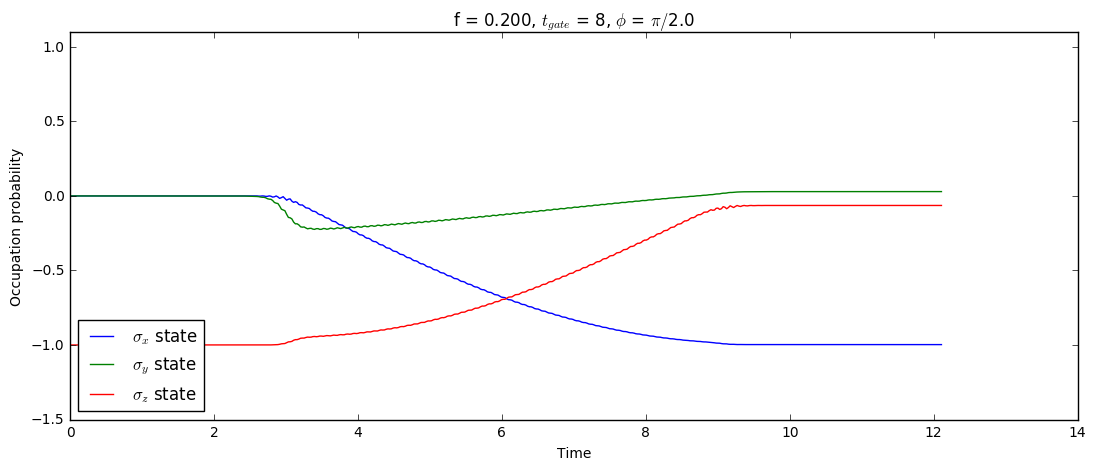

In [262]:
q.plot()

In [356]:
q.pulse[0] = p1

In [357]:
ideal = my_hadamard()
q.fidelity(ideal)

0.999629931764446

In [240]:
q.solveRF()

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.15s. Est. time left: 00:00:00:00
40.0%. Run time:   0.21s. Est. time left: 00:00:00:00
50.0%. Run time:   0.26s. Est. time left: 00:00:00:00
60.0%. Run time:   0.31s. Est. time left: 00:00:00:00
70.0%. Run time:   0.38s. Est. time left: 00:00:00:00
80.0%. Run time:   0.44s. Est. time left: 00:00:00:00
90.0%. Run time:   0.49s. Est. time left: 00:00:00:00
Total run time:   0.55s


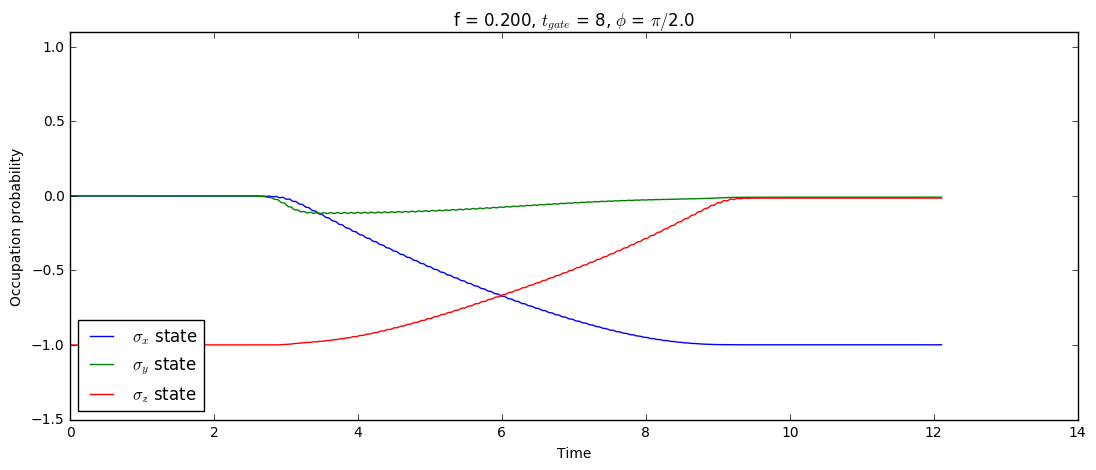

In [241]:
q.plot()

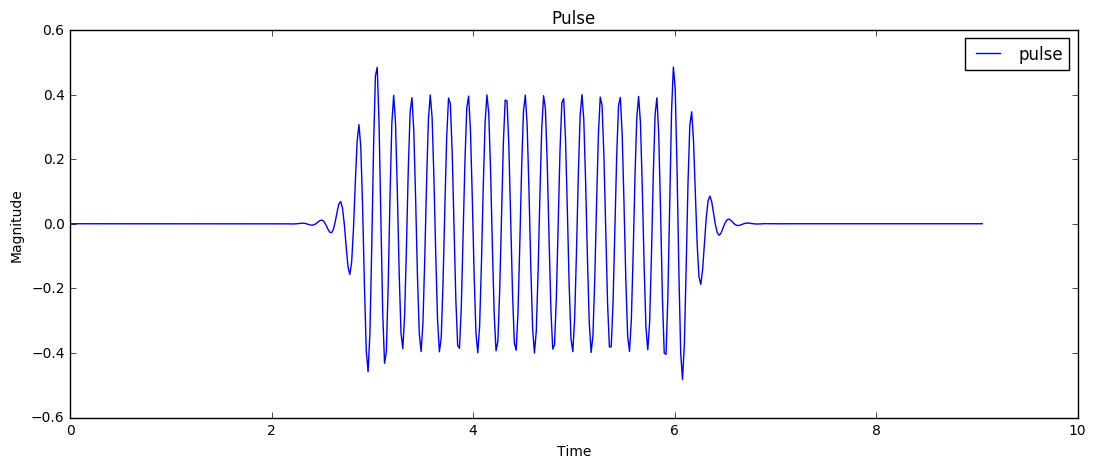

In [122]:
p.plot()

In [285]:
p.extra['b']-p.extra['a']

array([ 14.0571788])

In [61]:
def best_pulse_width(qubit, ideal_gate, relax_m = 0, init_guess = 100):
    qubit.update(params={'gamma_m':relax_m})
    def finder(t):
        qubit.pulse[0].set_width(float(np.real(t[0])))
        return 1 - qubit.fidelity(ideal_gate)
    return (fsolve(finder, init_guess),qubit.fidelity(ideal_gate))

In [62]:
ideal = my_hadamard()
q = SingleQND()
p = PulseNXYDrag(params=  {'f':0.3, 'a':2, 'phase':np.pi/2, 'axe' : PulseNXY.aroundY },time = {'maxtime' : 70,'points':100}, extra = {'qubit' : q,'default':False})
q.pulse[0] = p

In [63]:
best_width, best_fidelity = best_pulse_width(q,my_hadamard(), (1.5e3)**(-1), 500)

{'params': {'gamma_m': 0.0006666666666666666}}
{'params': {'w': 33.398321459947766}, 'time': None, 'shape': None}
{'params': {'width': 500.0}}


KeyboardInterrupt: 

In [133]:
1 - best_fidelity

0.9965341101699239

In [107]:
np.linspace(200, 400 , 11)

array([ 200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,  360.,
        380.,  400.])

In [110]:
tlist2 = np.linspace(200, 400 , 11)
flist2 = [q.update_pulse(params={'width':t}).fidelity(my_hadamard()) for t in tlist2]

{'shape': None, 'time': None, 'params': {'width': 200.0}}
{'shape': None, 'time': None, 'params': {'width': 220.0}}
{'shape': None, 'time': None, 'params': {'width': 240.0}}
{'shape': None, 'time': None, 'params': {'width': 260.0}}
{'shape': None, 'time': None, 'params': {'width': 280.0}}
{'shape': None, 'time': None, 'params': {'width': 300.0}}
{'shape': None, 'time': None, 'params': {'width': 320.0}}
{'shape': None, 'time': None, 'params': {'width': 340.0}}
{'shape': None, 'time': None, 'params': {'width': 360.0}}
{'shape': None, 'time': None, 'params': {'width': 380.0}}
{'shape': None, 'time': None, 'params': {'width': 400.0}}


In [111]:
print(len(tlist2))
print(len(flist2))

11
11


In [127]:
q.update_pulse(params={'width':1000}).solveRF()

{'shape': None, 'time': None, 'params': {'width': 1000}}
10.0%. Run time: 108.66s. Est. time left: 00:00:16:17
20.0%. Run time: 306.51s. Est. time left: 00:00:20:26
30.0%. Run time: 504.63s. Est. time left: 00:00:19:37
40.0%. Run time: 702.92s. Est. time left: 00:00:17:34
50.0%. Run time: 900.56s. Est. time left: 00:00:15:00
60.0%. Run time: 1098.33s. Est. time left: 00:00:12:12
70.0%. Run time: 1296.84s. Est. time left: 00:00:09:15
80.0%. Run time: 1494.18s. Est. time left: 00:00:06:13
90.0%. Run time: 1691.06s. Est. time left: 00:00:03:07
Total run time: 1887.70s


In [126]:
q.update(params={'N':10,'gamma_m':0.666e-3})

{'params': {'N': 10, 'gamma_m': 0.000666}}
{'shape': None, 'time': None, 'params': {'w': 33.335851782801299}}


/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


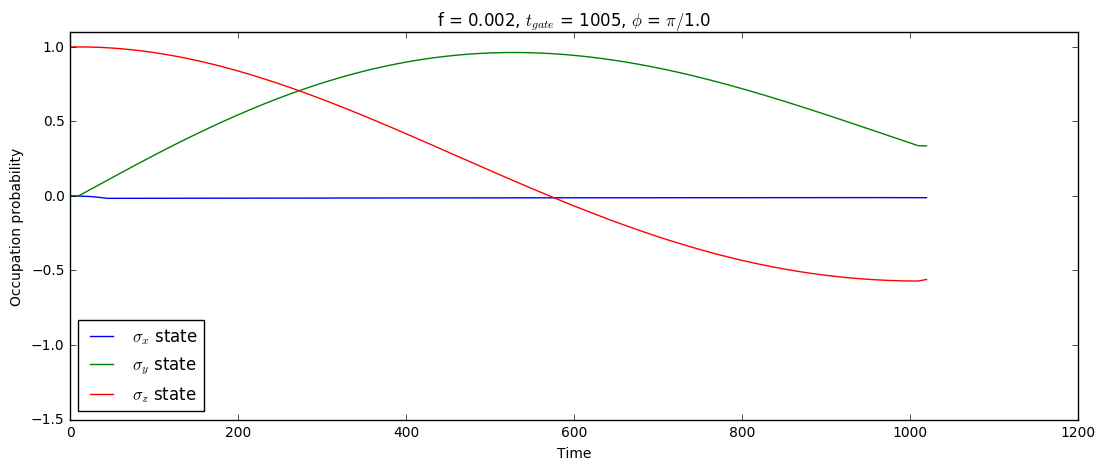

In [129]:
q.plot()

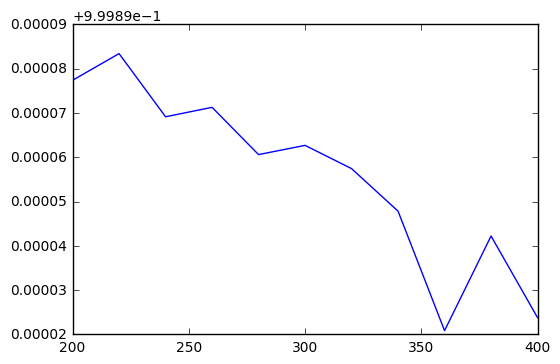

In [112]:
plt.plot(tlist2,flist2)

In [116]:
flist2

[0.9999673896472165,
 0.9999734158252428,
 0.9999591528995019,
 0.9999612830643774,
 0.9999506129218971,
 0.9999526963278007,
 0.9999474430094873,
 0.9999378376734835,
 0.9999108527889901,
 0.9999322254976142,
 0.9999137917582485]

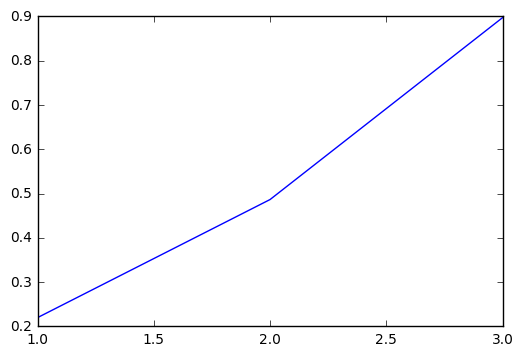

In [497]:
plt.plot(times,fidelity_list)

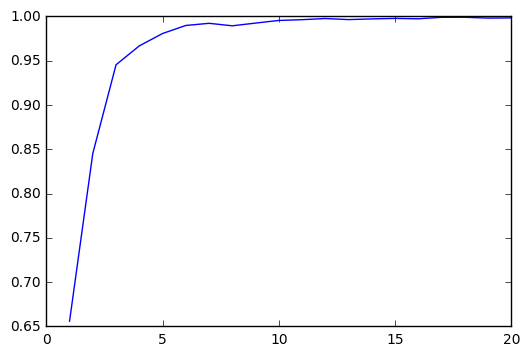

In [494]:
plt.plot(times,fidelity_list)

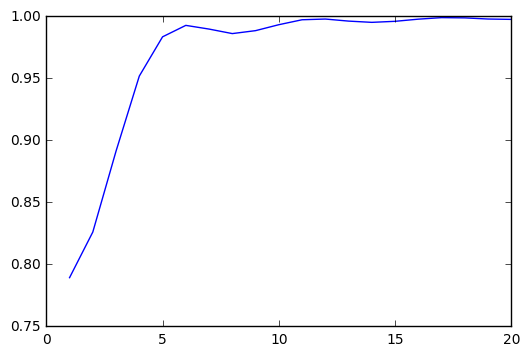

In [424]:
plt.plot(times,fidelity_list)

# NOT works

In [500]:
testq = SingleQND()

g = PulseNXYDrag(params = { 'a': 5, 'f' : 0.3,'phase':np.pi/2,'st':0.5,'axe':PulseNXY.aroundY },
                  time = {'maxtime' : 20,'points':200}, extra = {'qubit' : testq,'default':False})

testq.params['psi0'] = (testq.evecs[0] + testq.evecs[1])/(2)**0.5
#g.params['axe'] = np.pi
testq.pulse[0]=g

In [501]:
print(testq.args())
#testq.params['axe']


{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}
{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}


In [502]:
print(g.shape)

0.22821600457627*f*((-tanh((-a + t)/st)**2 + 1)/st - (-tanh((-b + t)/st)**2 + 1)/st)*sin(axe + t*w) + 0.5*f*(tanh((-a + t)/st) - tanh((-b + t)/st))*cos(axe + t*w)


{'f': 0.3, 'a': 5, 'axe': 1.5707963267948966, 'b': 9.0717102410319317, 'phase': 1.5707963267948966, 'st': 0.5, 'w': 33.398321459947766}
10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.14s. Est. time left: 00:00:00:00
40.0%. Run time:   0.19s. Est. time left: 00:00:00:00
50.0%. Run time:   0.23s. Est. time left: 00:00:00:00
60.0%. Run time:   0.27s. Est. time left: 00:00:00:00
70.0%. Run time:   0.32s. Est. time left: 00:00:00:00
80.0%. Run time:   0.36s. Est. time left: 00:00:00:00
90.0%. Run time:   0.40s. Est. time left: 00:00:00:00
Total run time:   0.44s


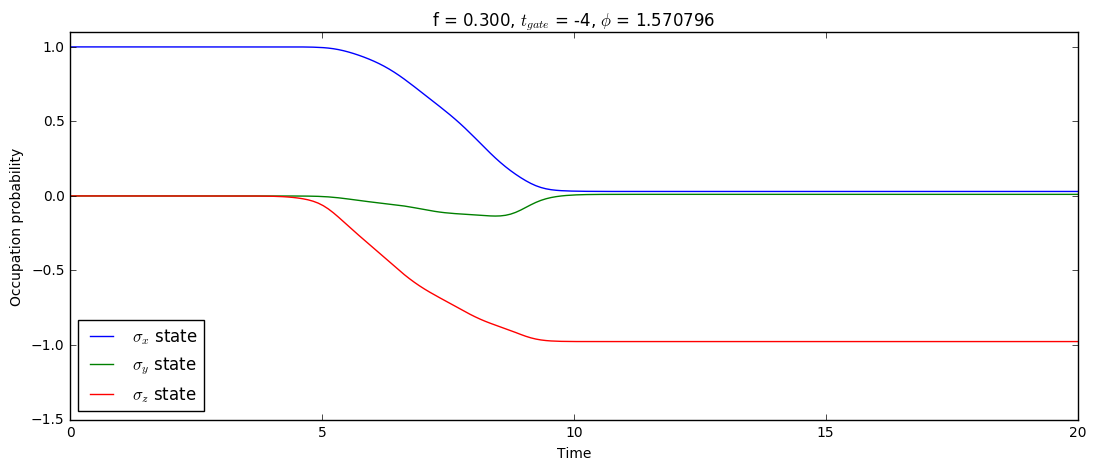

In [503]:
testq.solveRF()
testq.plot()

10.0%. Run time:   1.99s. Est. time left: 00:00:00:17
20.0%. Run time:   3.97s. Est. time left: 00:00:00:15
30.0%. Run time:   5.83s. Est. time left: 00:00:00:13
40.0%. Run time:   7.60s. Est. time left: 00:00:00:11
50.0%. Run time:   9.52s. Est. time left: 00:00:00:09
60.0%. Run time:  11.44s. Est. time left: 00:00:00:07
70.0%. Run time:  13.45s. Est. time left: 00:00:00:05
80.0%. Run time:  15.37s. Est. time left: 00:00:00:03
90.0%. Run time:  17.25s. Est. time left: 00:00:00:01
Total run time:  19.15s


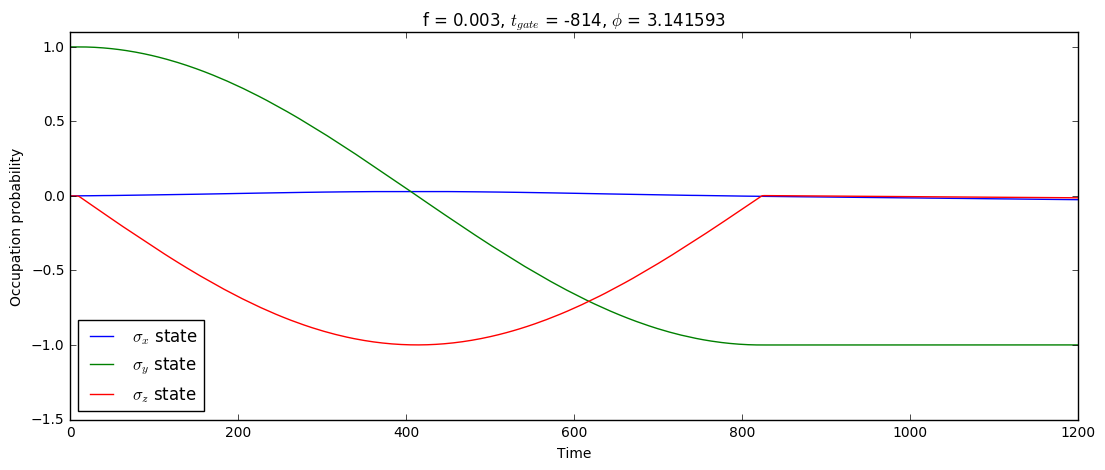

In [454]:
testq.solveRF()
testq.plot()

In [437]:
m2 = SingleQND()
pn = PulseNXYDrag(params = { 'a': 5, 'f' : 0.3,'phase':-np.pi/2,'st':0.5, 'axe':0 },
                  time = {'maxtime' : 20,'points':1000}, extra = {'qubit' : m2,'default':False})
pn.params['axe']

3.141592653589793